In [1]:
from google.colab import files
uploaded = files.upload()

Saving Womens Clothing E-Commerce Reviews.csv to Womens Clothing E-Commerce Reviews.csv


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Epoch 1/2 - Train Loss: 0.4247 | Val Loss: 0.3129 | Val Acc: 0.8736
Epoch 2/2 - Train Loss: 0.2416 | Val Loss: 0.2812 | Val Acc: 0.8847

Classification Report:
              precision    recall  f1-score   support

    Negative       0.51      0.89      0.65       474
    Positive       0.98      0.88      0.93      3490

    accuracy                           0.88      3964
   macro avg       0.75      0.89      0.79      3964
weighted avg       0.93      0.88      0.90      3964


Accuracy: 0.8847124117053481


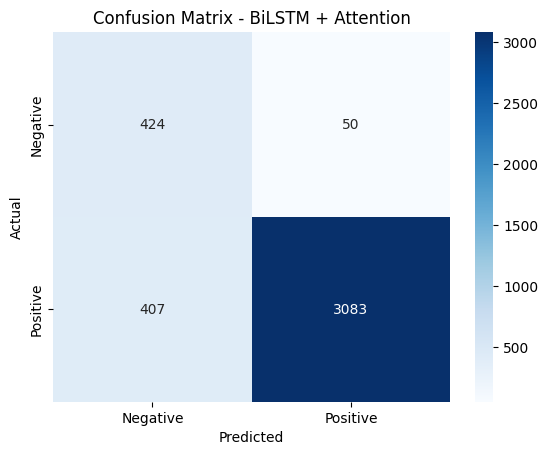

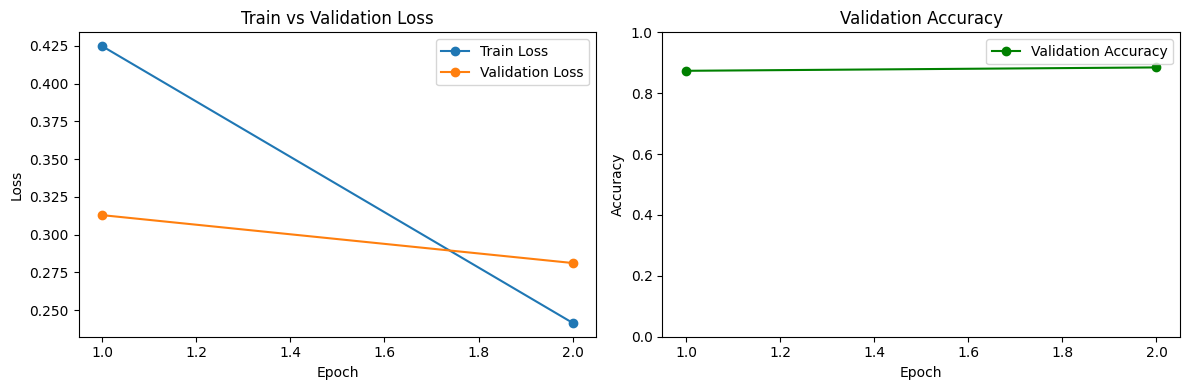


--- Kiểm thử mô hình trên đánh giá mới ---
Review: This dress is fantastic! I love it!
→ Predicted Sentiment: Positive

Review: The fabric is terrible and it ripped easily.
→ Predicted Sentiment: Negative

Review: I am very satisfied with this purchase, great quality!
→ Predicted Sentiment: Positive

Review: Poorly made, not worth the money.
→ Predicted Sentiment: Negative

Review: Absolutely love this! Fits perfectly.
→ Predicted Sentiment: Positive

Review: Not happy at all, bad experience.
→ Predicted Sentiment: Negative

Review: Wonderful fabric and excellent design!
→ Predicted Sentiment: Positive

Review: Size was incorrect and material feels cheap.
→ Predicted Sentiment: Negative

Review: The product is okay, not great but not bad either.
→ Predicted Sentiment: Negative

Review: I'm on the fence about this one.
→ Predicted Sentiment: Positive



In [ ]:
#18s
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import re
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
# Tải tài nguyên NLTK
nltk.download('punkt_tab')
nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
# 1. Đọc và xử lý dữ liệu
df = pd.read_csv("Womens Clothing E-Commerce Reviews.csv")
df = df.dropna(subset=['Review Text', 'Rating'])
df = df[df['Rating'] != 3]
df['Sentiment'] = df['Rating'].apply(lambda x: 1 if x > 3 else 0)

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    tokens = word_tokenize(text)
    tokens = [t for t in tokens if t not in stop_words]
    return ' '.join(tokens).strip()

df['Cleaned'] = df['Review Text'].apply(clean_text)

# 2. Tokenization thủ công (với vocabulary nhỏ)
from collections import Counter

all_text = " ".join(df['Cleaned'])
words = all_text.split()
word_counts = Counter(words)
vocab = {word: idx + 2 for idx, (word, _) in enumerate(word_counts.most_common())}
vocab["<PAD>"] = 0
vocab["<UNK>"] = 1

def encode_text(text, max_len=100):
    tokens = text.split()
    ids = [vocab.get(token, vocab["<UNK>"]) for token in tokens]
    ids = ids[:max_len] + [vocab["<PAD>"]] * (max_len - len(ids))
    return ids

df['encoded'] = df['Cleaned'].apply(lambda x: encode_text(x, max_len=100))

# 3. Train-test split
X = np.array(df['encoded'].tolist())
y = np.array(df['Sentiment'].tolist())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# 4. Dataset & DataLoader
class ReviewDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.LongTensor(X)
        self.y = torch.LongTensor(y)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_data = ReviewDataset(X_train, y_train)
test_data = ReviewDataset(X_test, y_test)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32)

# 5. BiLSTM + Attention Model
class BiLSTMAttention(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, hidden_dim=128, num_classes=2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.attn = nn.Linear(hidden_dim * 2, 1)
        self.classifier = nn.Linear(hidden_dim * 2, num_classes)

    def forward(self, x):
        embedded = self.embedding(x)  # [B, T, D]
        lstm_out, _ = self.lstm(embedded)  # [B, T, 2H]
        attn_weights = torch.softmax(self.attn(lstm_out).squeeze(-1), dim=1)  
        context = torch.sum(lstm_out * attn_weights.unsqueeze(-1), dim=1)  
        logits = self.classifier(context)
        return logits

# 6. Huấn luyện
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BiLSTMAttention(vocab_size=len(vocab)).to(device)

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
loss_fn = nn.CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float).to(device))
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 2
train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = loss_fn(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Đánh giá trên tập validation
    model.eval()
    val_loss = 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = loss_fn(outputs, y_batch)
            val_loss += loss.item()
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(y_batch.cpu().numpy())
    avg_val_loss = val_loss / len(test_loader)
    val_losses.append(avg_val_loss)
    accuracy = accuracy_score(all_labels, all_preds)
    val_accuracies.append(accuracy)

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {accuracy:.4f}")

# 7. Đánh giá
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(y_batch.numpy())

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=["Negative", "Positive"]))
print("\nAccuracy:", accuracy_score(all_labels, all_preds))

# 8. Ma trận nhầm lẫn
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Negative", "Positive"],
            yticklabels=["Negative", "Positive"])
plt.title("Confusion Matrix - BiLSTM + Attention")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
new_reviews = [
    "This dress is fantastic! I love it!",
    "The fabric is terrible and it ripped easily.",
    "I am very satisfied with this purchase, great quality!",
    "Poorly made, not worth the money.",
    "Absolutely love this! Fits perfectly.",
    "Not happy at all, bad experience.",
    "Wonderful fabric and excellent design!",
    "Size was incorrect and material feels cheap.",
    "The product is okay, not great but not bad either.",
    "I'm on the fence about this one."
]
# Vẽ biểu đồ loss và accuracy
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 4))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(epochs, val_accuracies, label='Validation Accuracy', marker='o', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.ylim(0, 1)
plt.legend()

plt.tight_layout()
plt.show()
def preprocess_and_encode(texts, vocab, max_len=100):
    cleaned = [clean_text(t) for t in texts]
    encoded = []
    for text in cleaned:
        tokens = text.split()
        ids = [vocab.get(token, vocab["<UNK>"]) for token in tokens]
        ids = ids[:max_len] + [vocab["<PAD>"]] * (max_len - len(ids))
        encoded.append(ids)
    return torch.LongTensor(encoded)

# Tiền xử lý
X_new = preprocess_and_encode(new_reviews, vocab).to(device)

# Dự đoán
model.eval()
with torch.no_grad():
    outputs = model(X_new)
    preds = torch.argmax(outputs, dim=1).cpu().numpy()

print("\n--- Kiểm thử mô hình trên đánh giá mới ---")
for review, pred in zip(new_reviews, preds):
    sentiment = "Positive" if pred == 1 else "Negative"
    print(f"Review: {review}\n→ Predicted Sentiment: {sentiment}\n")